# Forecasting stratigies

There are 5 possible forecasting strategies: Recursive, Direct, DirRec, MIMO, DIRMO. The first two of these were implemented in ETNA, and we will take a closer look at them in this notebook.

Notebook navigation:
* [Load dataset](#1-load-dataset)
* [Recursive strategy](#2-recursive-strategy)
    * [AutoRegressivePipeline](#21-autoregressivepipeline)
* [Direct strategy](#3-direct-strategies)
    * [Pipeline](#31-pipeline)
    * [DirectEnsemble](#32-directensemble)
    * [assemble_pipelines + DirectEnsemble](#33-assemble-pipelines-with-ensembles-method-assemblepipelines-class-directensemble)
* [Summary](#4summary)

In [1]:
import warnings

warnings.filterwarnings("ignore")

## 1. Load Dataset

Let's load and plot the dataset:

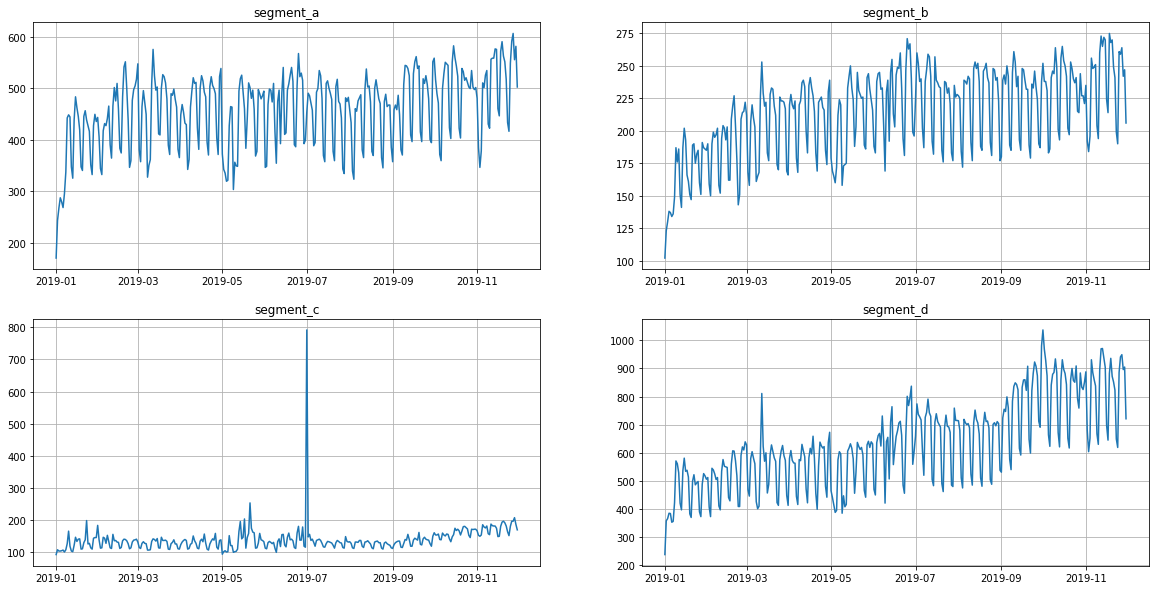

In [2]:
import pandas as pd
from etna.datasets import TSDataset

df = pd.read_csv("data/example_dataset.csv")
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

ts.plot()

In [3]:
HORIZON = 14

## 2. Recursive strategy

### 2.1 AutoRegressivePipeline

AutoRegressive pipeline is pipeline, which iteratively forecasts `step` values and after that uses forecasted values as features. `step` is parameter of AutoregressivePipeline and it should be less than `HORIZON`.

* This method allows to use lags, that are lower than `HORIZON`
* AutoRegressivePipeline could be imprecise on forecastings with large horizons. The thing is that we accumulate errors of forecastins for further horizons. 
* Could be slow if you choose low `step`, because method needs to recalculate features $\frac{horizon}{step}$ times
* Stable for noise-free time series

##### Note:
As features we will use linear trend transform(because we are working with tree-based models) and lags of input series

In [4]:
from etna.pipeline import AutoRegressivePipeline
from etna.models import CatBoostModelPerSegment
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.metrics import SMAPE, MAE, MAPE

model = CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=[i for i in range(1, 20)], out_column="target_lag"),
]

autoregressivepipeline = AutoRegressivePipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_recursive_df, forecast_recursive_df, _ = autoregressivepipeline.backtest(
    ts=ts, metrics=[SMAPE(), MAE(), MAPE()]
)
autoregressive_pipeline_metrics = metrics_recursive_df.mean(0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.8s finished


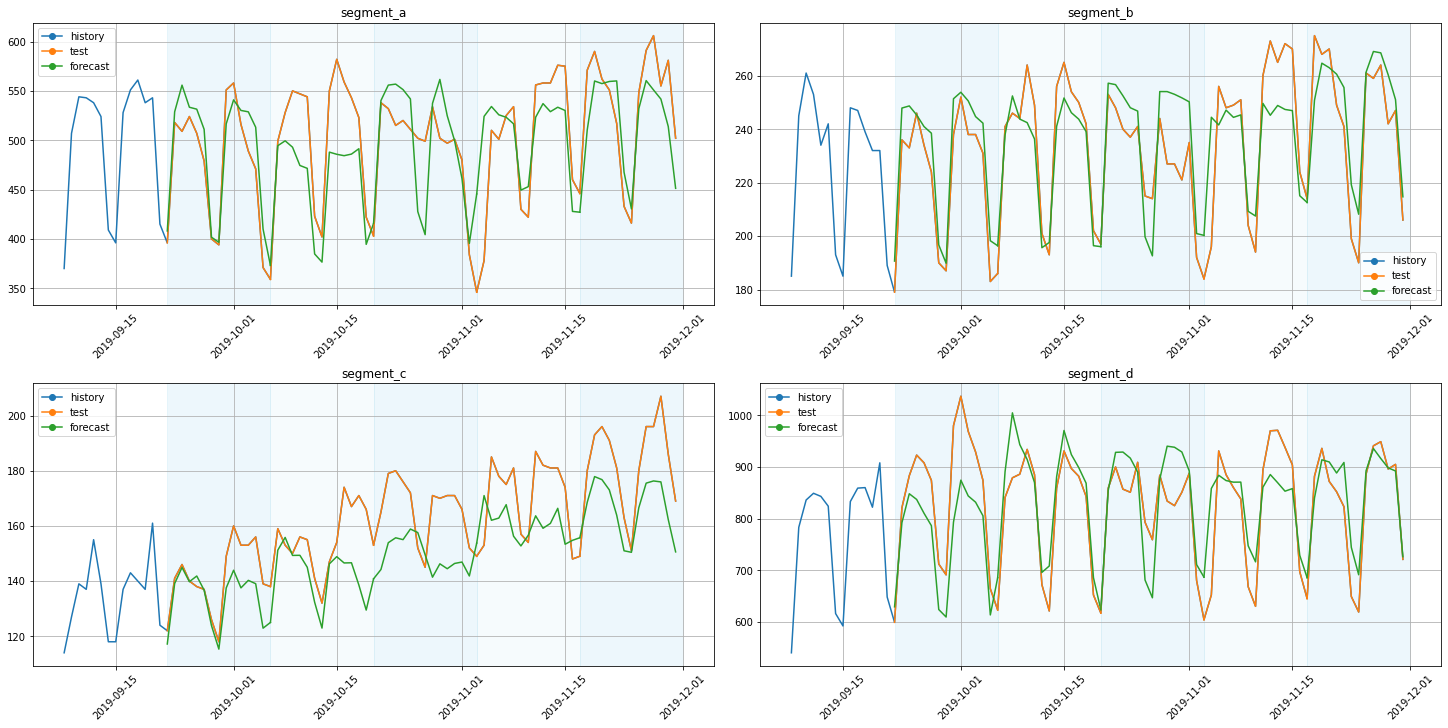

In [5]:
from etna.analysis import plot_backtest

plot_backtest(forecast_recursive_df, ts, history_len=HORIZON)

## 3. Direct Strategies

### 3.1 Pipeline

Pipeline is a base strategy of forecasting. It accepts as input model, fit only one model for all forecastings. In forecast method independently of each other calculates features and put it in model.


* Pipelines don't accepts lags less than `horizon`
* This is the most time-efficient method: both in traning and in forecasting
* This method can be effective when we forecast in small horizons. If we use lags of series as features, in large horizons we use large lags of series, which can be not actual for our forecastings.
* Method assumes conditional independence of forecasts


In [6]:
from etna.pipeline import Pipeline

model = CatBoostModelPerSegment()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=list(range(HORIZON, 40)), out_column="target_lag"),
]

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_pipeline_df, forecast_pipeline_df, _ = pipeline.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])
pipeline_metrics = metrics_pipeline_df.mean(axis=0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


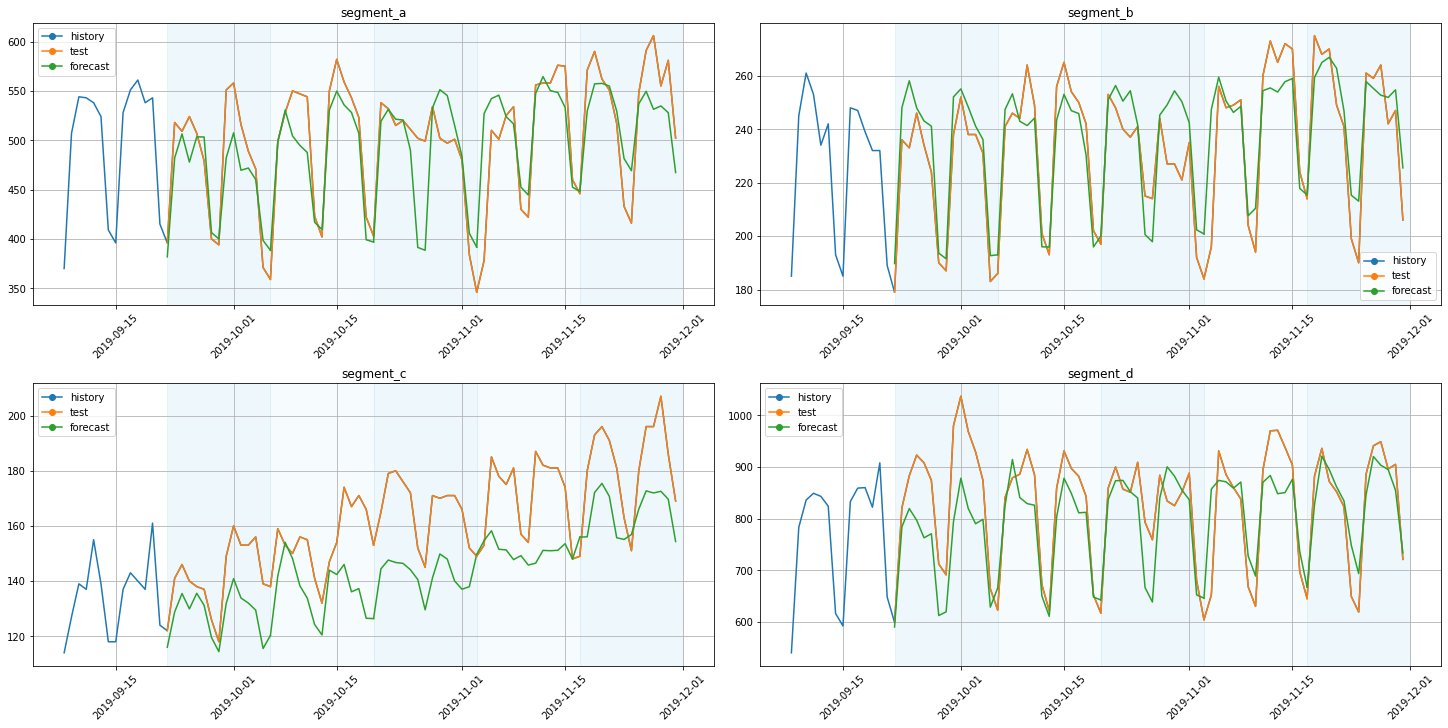

In [7]:
plot_backtest(forecast_pipeline_df, ts, history_len=HORIZON)

### 3.2 DirectEnsemble 

DirectEnsemble is a pipeline that forecasts future values merging the forecasts of the base pipelines. For each future value we select base pipeline with shortest horizon that spans the timestamp of interesitng value. Let's see an example of choosing base-pipeline for forecastings:

![title](./assets/forecasting_strategies/ensemle.png)



* This method can be useful when we have different pipelines, that are effective on different horizons.
* A lot of time is spent on training and forecasting, because the ensemble has multiple models and makes useless calculations in the forecasting step.

#### Example
 Let we know that pipeline with `CatBoost` model is effective than `NaiveModel` on small horizons, and on the contrary, `NaiveModel` is better on large `horizons`. It is logical to conclude, that it's better to forecast first points with `NaiveModel` and others with `CatBoost` and achieve better performance, than both models individually. However, this approach requires more time, because we calculate values, that are not used in final forecastings. In our example we need to forecast first few points for `CatBoost` and these forecasted values are not used in final forecastings.

First, let's build our pipelines:

In [8]:
from etna.models import NaiveModel

horizons = [10, 14]

model_1 = CatBoostModelPerSegment()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=[i for i in range(10, 20)], out_column="target_lag"),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = NaiveModel(lag=3)
transforms_2 = []

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

Secondly, we will create ensemble and forecasts:

In [10]:
from etna.ensembles import DirectEnsemble

ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

metrics_ensemble_df, forecast_ensemble_df, _ = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])
ensemble_metrics = metrics_ensemble_df.mean(axis=0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    

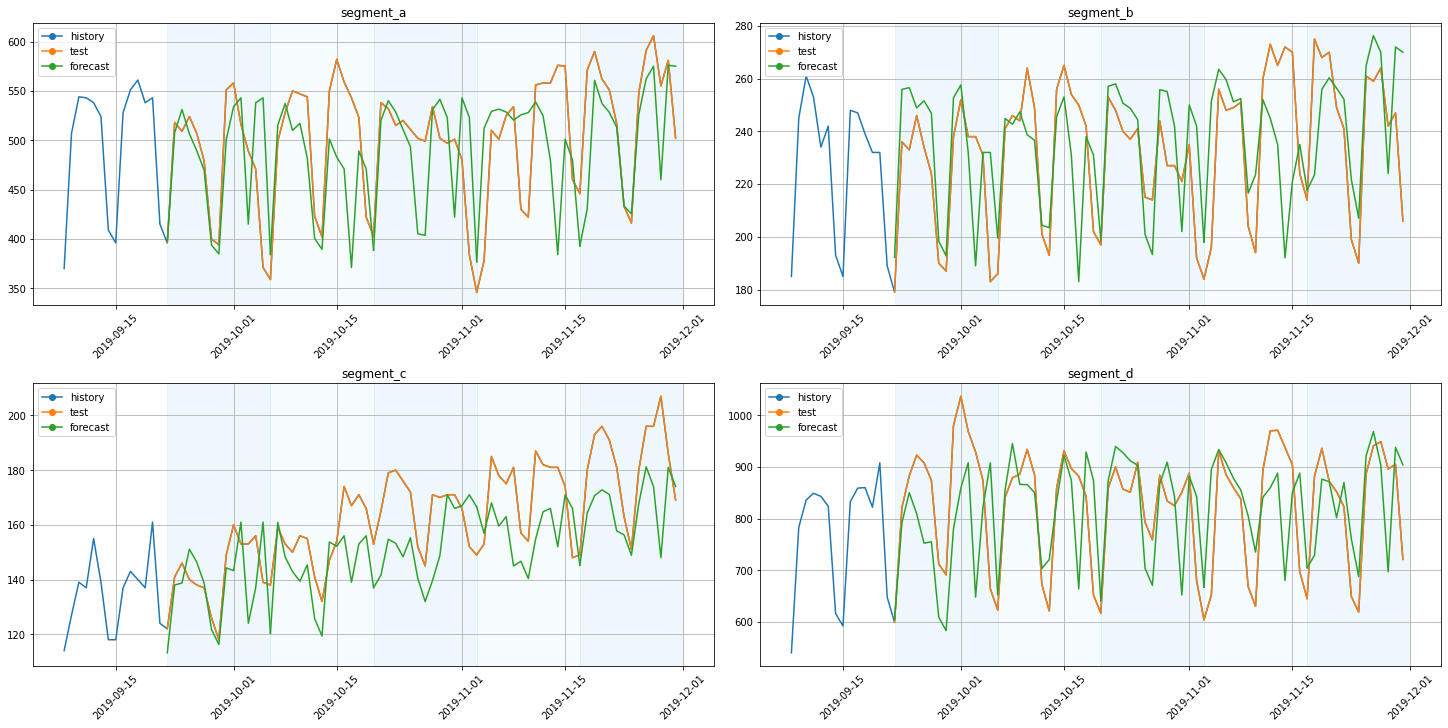

In [11]:
plot_backtest(forecast_ensemble_df, ts, history_len=HORIZON)

### 3.3 assemble pipelines with DirectEnsemble

DirectEnsemble has been described above, so let's take a look at assemble pipelines. `assemble_pipelines` is a function, that generates `Pipelines` from a set of input models, transforms and horizons according to some rules:

1. Input models can be specified as one model or as a sequence of models. In first case all generated pipelines will have input model and in the second case `i`-th pipeline will hold `i`-th model. 
2. Similar to paragraph 1, but for horizons.
3. Transforms can be specified as a sequence of transform or as a sequence of sequence of transforms. Let's look at some examples to understand better transformations with transforms:

Let's consider that `A`, `B`, `C`, `D`, `E` are different transforms.

### Example 1

If input transform sequence is `[A, B, C]`, function will transformate in `[A, B, C]` for each pipeline

### Example 2

If input transform sequence is `[A, [B, C], D, E]`, function will put `[A, B, D, E]` for the first generated pipeline and `[A, C, D, E]` for the second.

### Example 3

If input transform sequence is `[A, [B, C], [D, E]]`, function will put `[A, B, D]` for the first generated pipeline and `[A, C, E]` for the second.

### Example 4

If input transform sequence is `[A, [B, None]]`, function will put `[A, B]` for the first generated pipeline and `[A]` for the second.


This function can be comfortable for generating pipelines for DirectEnsemble, let's override our previous pipelines:


In [12]:
from etna.pipeline import assemble_pipelines

models = [CatBoostModelPerSegment(), NaiveModel(lag=3)]
transforms = [
    [LinearTrendTransform(in_column="target"), None],
    [LagTransform(in_column="target", lags=[i for i in range(10, 20)], out_column="target_lag"), None],
]
horizons = [10, 14]

pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)
pipelines

[Pipeline(model = CatBoostModelPerSegment(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], out_column = 'target_lag', )], horizon = 10, ),
 Pipeline(model = NaiveModel(lag = 3, ), transforms = [], horizon = 14, )]

Now pipelines generation look a bit simpler and we can put our pipelines into DirectEnsemble:

In [13]:
ensemble = DirectEnsemble(pipelines=pipelines)

metrics_ensemble_df_2, forecast_ensemble_df_2, _ = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    

Let's check that the forecastings has not changed in general:

In [14]:
eps = 1e-5

assert (abs(metrics_ensemble_df_2.drop("segment", 1) - metrics_ensemble_df.drop("segment", 1)) < eps).all().all()

## 4.Summary

In this notebook we discussed some forecasting strategies, look at their usage in ETNA. Finally, let's compare all metrics:

In [15]:
df_res = pd.DataFrame(
    data=[ensemble_metrics, pipeline_metrics, autoregressive_pipeline_metrics],
    index=["direct_ensemble", "pipeline", "autoregressive_pipeline"],
).drop("fold_number", axis=1)
df_res

,SMAPE,MAE,MAPE
direct_ensemble,9.345614,40.964906,9.229230
pipeline,7.324356,28.551458,7.093610
autoregressive_pipeline,6.983119,29.496753,6.896113
